<a href="https://colab.research.google.com/github/sameersundrani/STATS205_FinalProject_Bitcoin/blob/main/BTC_Nonparametric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import requests 
import json
from scipy.interpolate import UnivariateSpline

#cryto_data
!pip install Historic-Crypto
from Historic_Crypto import HistoricalData

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'STATS 205 Final Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [3]:
path_to_save = "/content/drive/MyDrive/STATS 205 Final Project/"

In [4]:
def gaussianKernalWeight(x_i, x, h):
  return (1/(math.sqrt(2*math.pi))) * math.exp(-1*(math.pow(((x_i - x)/ h),2) / 2))

def get_all_weights(orig_vec, x, h):
  return [gaussianKernalWeight(orig_vec[i], x, h) for i in range(len(orig_vec))]

def r_hat_gaussian(orig_vec, test_vec, y_vec, h):
    r_hat = []
    for i in range(len(test_vec)):
        gaussian_weights = get_all_weights(orig_vec, test_vec[i], h)
        weighted_pred = []
        for j in range(len(orig_vec)):
            weighted_pred.append(gaussian_weights[j]*y_vec[j])
        r_hat.append(sum(weighted_pred)/sum(gaussian_weights))
    return r_hat


#returns a vec of all b_j for a particular x  
def get_all_b(orig_vec, x, h):
  #there are num_example number of b's for each x
  all_b = [] 
  for j in range(len(orig_vec)):
    w_j = gaussianKernalWeight(orig_vec[j], x, h)
    u_j = orig_vec[j] - x
    all_w = get_all_weights(orig_vec, x, h)
    all_u = [orig_vec[i] - x for i in range(len(orig_vec))]
    sum_1 = sum([all_w[i]*(all_u[i] ** 2) for i in range(len(orig_vec))])
    sum_2 = sum([all_w[i]*all_u[i] for i in range(len(orig_vec))])
    all_b.append(w_j * ((sum_1) - u_j*(sum_2)))
  return all_b

#returns a vec of all l_j for a particular x  
def get_all_l(orig_vec, x, all_b):
  all_l = []
  sum_b = sum(all_b)
  return [(all_b[j] / sum_b) for j in range(len(all_b))]

#returns a float pred for a particular x  
def local_linear_r(all_l, all_y):
  return sum([all_l[i]*all_y[i] for i in range(len(all_l))])

def get_all_local_linear_r(orig_vec, test_vec, all_y, h, cross = False):
  r_hat = []
  l = []
  for i in range(len(test_vec)): 
    all_b_i = get_all_b(orig_vec, test_vec[i], h)
    all_l_i = get_all_l(orig_vec, test_vec[i], all_b_i)
    l.append(all_l_i)
    r_hat.append(local_linear_r(all_l_i, all_y))
  if cross: 
    return r_hat, l
  return r_hat

def cross_val(orig_vec, test_vec, all_y, h, cross):
  # r_hat, l = get_all_local_linear_r(orig_vec, test_vec, all_y, h, cross)
  r_hat = get_all_local_linear_r(orig_vec, test_vec, all_y, h, False)
  cv_score = []
  n = len(orig_vec)
  buf = len(r_hat)/n
  for i in range(n):
    all_b_i = get_all_b(orig_vec, test_vec[i], h)
    l_i = all_b_i[i] / sum(all_b_i)
    # cv_score += ((all_y[i] - r_hat[int(i * buf)])/(1 - l[int(i * buf)][i]))**2
    cv_score.append(((all_y[i] - r_hat[i])**2)/((1 - l_i)**2))
  #cv_score = ((np.array(all_y) @ np.array(r_hat)) @ (1-np.diag(l)).T)**2
  return sum(cv_score) / n

### use below for 2 layer NN
def initialize_weights(dim, tau):
  a = np.random.normal(0, tau, (dim,1))
  w = np.random.normal(0, tau, (dim,1))
  b = np.random.normal(0, tau, (dim,1))
  return a,w,b

def sigmoid(X):
   return 1/(1+np.exp(-X))

def tanh(x):
  t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
  return t

def gradient_descent(x,a,w,b,y, num_iter = 10**5, lr=.01, lambd=0):
  grad = 0
  loss_history = []
  m = a.shape[0]
  n = x.shape[0]
  print(lambd)
  for t in range(num_iter):
    # z = tanh(w @ x.T + b)
    z = np.maximum(w @ x.T + b, 0)
    # z = sigmoid(w @ x.T + b)
    f = (z.T @ a)
    loss = 1/(2*n) * np.sum((y - f)**2) + (lambd/2 * (np.linalg.norm(a)**2 + np.linalg.norm(w)**2))
    a_grad = 1/n * ((z @ (f - y))) + lambd * a
    w_grad = 1/n * (a * np.where(z > 0,1,0)) @ (x * (f-y)) + lambd * w
    b_grad = 1/n * ((a * np.where(z > 0,1,0)) @ (f - y))
    a -= lr * a_grad
    w -= lr * w_grad
    b -= lr * b_grad
    loss_history.append((loss,t))
    if t % 10000 == 0: 
      print("Loss at " + str(t) + ": " + str(loss))
      # if (t != 0 and np.linalg.norm(loss_history[t - 1][0] - loss_history[t][0]) < 10**-5):
      #   print("Loss at " + str(t) + ": " + str(loss))
      #   return a,w,b,loss_history
  return a,w,b,loss_history

def predict(x, a, w, b):
  # scores = tanh((w @ x.T) +b).T @ a
  scores = np.maximum((w @ x.T) +b,0).T @ a
  # scores = sigmoid(w @ x.T + b).T @ a
  return scores



## Data Prep (600, 300, 50 Days back from June 2nd 2021)

In [ ]:
#let's prep our data as just the closing price for the last 600 days
df_600 = HistoricalData('BTC-USD',86400,'2019-10-12-00-00','2021-06-02-00-00').retrieve_data()
df_btc = pd.DataFrame({'close': df_600.close})
df_btc.index = df_btc.index.map(pd.to_datetime)
df_btc = df_btc.sort_index()
df_btc = df_btc.apply(lambda x: np.log(x) - np.log(x.shift(1)))
df_600['logreturn'] = df_btc['close']
df_600 = df_600.iloc[1:, :]
df_600['time'] = range(1, 600)
df_600
df_600.to_csv(path_to_save + "BTC_600.csv")

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 1 extracted
Data for chunk 1 of 1 extracted


In [ ]:
#let's prep our data as just the closing price for the last 300 days
df_300 = HistoricalData('BTC-USD',86400,'2020-08-07-00-00','2021-06-02-00-00').retrieve_data()
df_btc = pd.DataFrame({'close': df_300.close})
df_btc.index = df_btc.index.map(pd.to_datetime)
df_btc = df_btc.sort_index()
df_btc = df_btc.apply(lambda x: np.log(x) - np.log(x.shift(1)))
df_300['logreturn'] = df_btc['close']
df_300 = df_300.iloc[1:, :]
df_300['time'] = range(1, 300)
df_300
df_300.to_csv(path_to_save + "BTC_300.csv")

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data Extracted from API...


In [ ]:
#let's prep our data as just the closing price for the last 50 days
df_50 = HistoricalData('BTC-USD',86400,'2021-04-14-00-00','2021-06-02-00-00').retrieve_data()
df_btc = pd.DataFrame({'close': df_50.close})
df_btc.index = df_btc.index.map(pd.to_datetime)
df_btc = df_btc.sort_index()
df_btc = df_btc.apply(lambda x: np.log(x) - np.log(x.shift(1)))
df_50['logreturn'] = df_btc['close']
df_50 = df_50.iloc[1:, :]
df_50['time'] = range(1, 50)
df_50
df_50.to_csv(path_to_save + "BTC_50.csv")

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data Extracted from API...


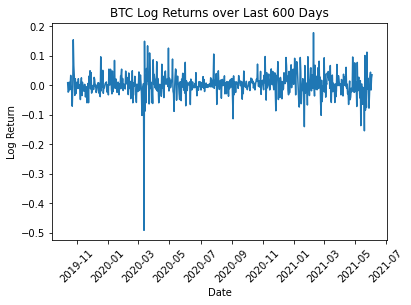

In [ ]:
#get starting plot for log return data
plt.plot(df_600.index, df_600['logreturn'], linestyle = '-', label = 'BTC')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation = 45)
plt.title('BTC Log Returns over Last 600 Days')
plt.savefig(path_to_save + 'BTC_log_return.png', bbox_inches = 'tight')

## Get data picture 

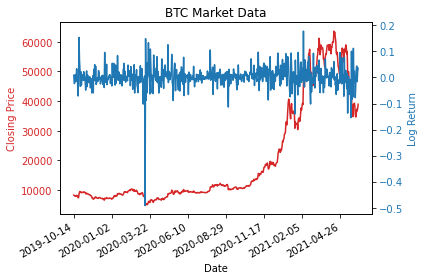

In [31]:
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.dates import DateFormatter
df_600 = pd.read_csv(path_to_save + 'BTC_600.csv')

fig, ax1 = plt.subplots()
ax1.set_title('BTC Market Data')
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(df_600.time, df_600.close, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.locator_params(axis ='x', nbins = 15)

max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax1.xaxis.set_major_locator(xloc)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Log Return', color=color)  # we already handled the x-label with ax1
ax2.plot(df_600.time, df_600.logreturn, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(xloc)
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path_to_save + 'BTC_datagraph.png', bbox_inches = 'tight')
plt.show()


## Neural Network (2-layer)

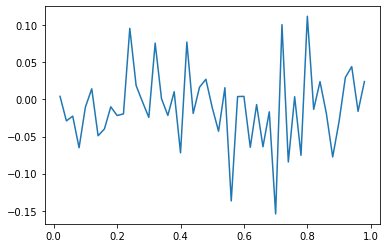

In [72]:
# 50 days 
path_data = path_to_save + "BTC_50.csv"
df_50 = pd.read_csv(path_data)

pre_x_val = list(df_50['time.1'])
pre_y_val = list(df_50.logreturn)


#90% train test split by time index
x_50 = np.array([float(num) for num in pre_x_val]).reshape(49,1)
x_50 /= 50
y_50 = np.array([float(num) for num in pre_y_val]).reshape(49,1)


plt.plot(x_50, y_50)


In [73]:
M = 200
tau =1.5
a,w,b = initialize_weights(M, tau)
a,w,b,loss_history = gradient_descent(x_50[0:44],a,w,b,y_50[0:44],lr=.001,lambd=0)

0
Loss at 0: 204.3232804643503
Loss at 10000: 0.0013353441925431414
Loss at 20000: 0.0011627140201311934
Loss at 30000: 0.0011202099003895358
Loss at 40000: 0.0010745475485771678
Loss at 50000: 0.0010417792223678828
Loss at 60000: 0.0010201150028150395
Loss at 70000: 0.0010113166960209392
Loss at 80000: 0.0010029754708852077
Loss at 90000: 0.0009972493512715576


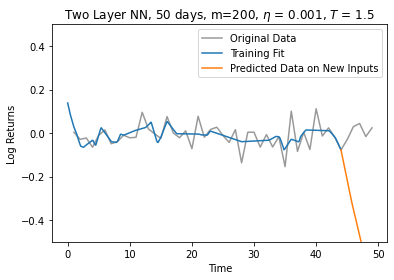

In [74]:
x_pred_50 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_50 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_50 = predict(x_pred_50, a, w, b)
y_pred2_50 = predict(x_pred2_50, a, w, b)
x_pred_50 *= 50
x_pred2_50 *= 50
plt.plot(x_50*50,y_50, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_50, y_pred_50, label = 'Training Fit')
plt.plot(x_pred2_50, y_pred2_50, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, 50 days, m=200, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_50_pred.',bbox_inches = 'tight')
plt.show()
#training loss = 0.001021220861116948
#testing loss =  0.029614521755662662

In [75]:
loss = 1/(2*5) * np.sum((predict(x_50[44:], a, w, b) - y_50[44:])**2)
print("test loss: ", loss)

test loss:  0.13224798590029585


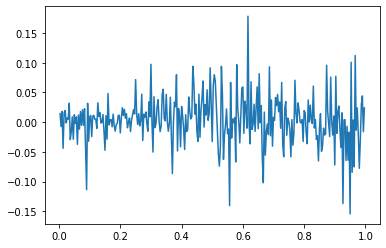

In [76]:
# 300 days 
path_data = path_to_save + "BTC_300.csv"
df_300 = pd.read_csv(path_data)

pre_x_val = list(df_300['time.1'])
pre_y_val = list(df_300.logreturn)


#90% train test split by time index
x_300 = np.array([float(num) for num in pre_x_val]).reshape(299,1)
x_300 /= 300
y_300 = np.array([float(num) for num in pre_y_val]).reshape(299,1)


plt.plot(x_300, y_300)

In [77]:
M = 1000
tau =1.5
a1,w1,b1 = initialize_weights(M, tau)
a1,w1,b1,loss_history1 = gradient_descent(x_300[0:270],a1,w1,b1,y_300[0:270],lr=.001,lambd=0)

0
Loss at 0: 9968.65299853059
Loss at 10000: 0.000896862893158744
Loss at 20000: 0.0007084328548470796
Loss at 30000: 0.0006489070335271432
Loss at 40000: 0.0006166956045729788
Loss at 50000: 0.0005988075038534209
Loss at 60000: 0.0005843266358979629
Loss at 70000: 0.0005727081613238657
Loss at 80000: 0.0005620584902764245
Loss at 90000: 0.0005527229831172778


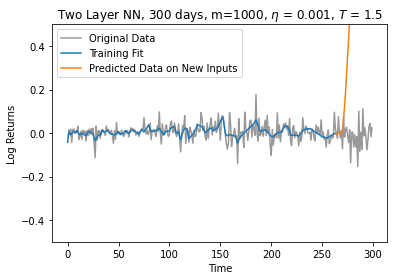

In [78]:
x_pred_300 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_300 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_300 = predict(x_pred_300, a1, w1, b1)
y_pred2_300 = predict(x_pred2_300, a1, w1, b1)
x_pred_300 *= 300
x_pred2_300 *= 300
plt.plot(x_300*300,y_300, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_300, y_pred_300, label = 'Training Fit')
plt.plot(x_pred2_300, y_pred2_300, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, 300 days, m=1000, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_300_pred.',bbox_inches = 'tight')
plt.show()

#training loss = 0.0006924497414655777
#testing loss =  0.06682559116048006

In [79]:
loss2 = 1/(2*30) * np.sum((predict(x_300[270:], a1, w1, b1) - y_300[270:])**2)
print("test loss: ", loss2)

test loss:  1.1900412407575374


In [80]:
# 600 days 
path_data = path_to_save + "BTC_600.csv"
df_600 = pd.read_csv(path_data)

pre_x_val = list(df_600['time.1'])
pre_y_val = list(df_600.logreturn)


#90% train test split by time index
x_600 = np.array([float(num) for num in pre_x_val]).reshape(599,1)
x_600 /= 600
y_600 = np.array([float(num) for num in pre_y_val]).reshape(599,1)

In [ ]:
M = 1200
tau =1.5
a2,w2,b2 = initialize_weights(M, tau)
a2,w2,b2,loss_history2 = gradient_descent(x_600[0:540],a2,w2,b2,y_600[0:540],lr=.001,lambd=0)

0
Loss at 0: 4914.17497313073
Loss at 10000: 0.0012733752859468142
Loss at 20000: 0.0009991123767695309
Loss at 30000: 0.0009216022735370248
Loss at 40000: 0.0008824322763398821
Loss at 50000: 0.0008595006383429463
Loss at 60000: 0.0008441040619578792
Loss at 70000: 0.0008315323457001409
Loss at 80000: 0.0008217711477431139
Loss at 90000: 0.0008126394635030684


In [ ]:
x_pred_600 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_600 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_600 = predict(x_pred_600, a2, w2, b2)
y_pred2_600 = predict(x_pred2_600, a2, w2, b2)
x_pred_600 *= 600
x_pred2_600 *= 600
plt.plot(x_600*600,y_600, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_600, y_pred_600, label = 'Training Fit')
plt.plot(x_pred2_600, y_pred2_600, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, 600 days, m=1200, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_600_pred.',bbox_inches = 'tight')
plt.show()
#train loss: 0.000783835534418538
#test loss:  0.06742516724645628

In [ ]:
loss3 = 1/(2*60) * np.sum((predict(x_600[540:], a2, w2, b2) - y_600[540:])**2)
print("test loss: ", loss3)

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=3,sharey = True, figsize = (15, 5))
axes[0].plot(x_50*50,y_50, alpha = 0.8, color = 'grey', label = "Original Data")
axes[0].plot(x_pred_50, y_pred_50, label = 'Training Fit')
axes[0].plot(x_pred2_50, y_pred2_50, label = 'Predicted Data on New Inputs')
axes[0].legend(loc = 'lower right')
axes[1].plot(x_300*300,y_300, alpha = 0.8, color = 'grey', label = "Original Data")
axes[1].plot(x_pred_300, y_pred_300, label = 'Training Fit')
axes[1].plot(x_pred2_300, y_pred2_300, label = 'Predicted Data on New Inputs')
axes[1].legend(loc = 'lower right')
axes[2].plot(x_600*600,y_600, alpha = 0.8, color = 'grey', label = "Original Data")
axes[2].plot(x_pred_600, y_pred_600, label = 'Training Fit')
axes[2].plot(x_pred2_600, y_pred2_600, label = 'Predicted Data on New Inputs')
axes[2].legend(loc = 'lower right')
axes[0].set_title('50 Days NN, m=200')
axes[0].set_xlabel('Days')
axes[1].set_title('300 Days NN, m=1000')
axes[1].set_xlabel('Days')
axes[2].set_title('600 Days NN, m=1200')
axes[2].set_xlabel('Days')
axes[0].set_ylabel('Log Return')
figure.tight_layout()
figure.savefig(path_to_save + 'two_layer_NN_pred.',bbox_inches = 'tight')



## Neural Network (2-layer) - regularized

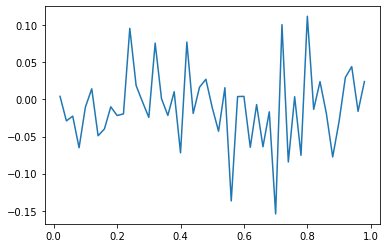

In [7]:
# 50 days 
path_data = path_to_save + "BTC_50.csv"
df_50 = pd.read_csv(path_data)

pre_x_val = list(df_50['time.1'])
pre_y_val = list(df_50.logreturn)


#90% train test split by time index
x_50 = np.array([float(num) for num in pre_x_val]).reshape(49,1)
x_50 /= 50
y_50 = np.array([float(num) for num in pre_y_val]).reshape(49,1)


plt.plot(x_50, y_50)

In [8]:
M = 200
tau =1.5
a3,w3,b3 = initialize_weights(M, tau)
a3,w3,b3,loss_history3 = gradient_descent(x_50[0:44],a3,w3,b3,y_50[0:44],lr=.001,lambd=0.005)

0.005
Loss at 0: 164.57455147900887
Loss at 10000: 2.1136624487648814
Loss at 20000: 1.9128395357250783
Loss at 30000: 1.7311323759975756
Loss at 40000: 1.5668981161969326
Loss at 50000: 1.4180552036004288
Loss at 60000: 1.2833946072206672
Loss at 70000: 1.1614300882793425
Loss at 80000: 1.0513353821917752
Loss at 90000: 0.951810061791767


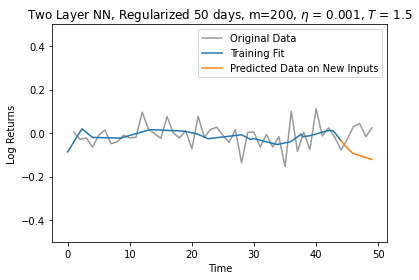

In [9]:
x_pred_50 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_50 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_50 = predict(x_pred_50, a3, w3, b3)
y_pred2_50 = predict(x_pred2_50, a3, w3, b3)
x_pred_50 *= 50
x_pred2_50 *= 50
plt.plot(x_50*50,y_50, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_50, y_pred_50, label = 'Training Fit')
plt.plot(x_pred2_50, y_pred2_50, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, Regularized 50 days, m=200, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_50_pred_reg.',bbox_inches = 'tight')
plt.show()

In [10]:
# 300 days 
path_data = path_to_save + "BTC_300.csv"
df_300 = pd.read_csv(path_data)

pre_x_val = list(df_300['time.1'])
pre_y_val = list(df_300.logreturn)


#90% train test split by time index
x_300 = np.array([float(num) for num in pre_x_val]).reshape(299,1)
x_300 /= 300
y_300 = np.array([float(num) for num in pre_y_val]).reshape(299,1)

In [11]:
M = 1000
tau =1.5
a4,w4,b4= initialize_weights(M, tau)
a4,w4,b4,loss_history4 = gradient_descent(x_300[0:270],a4,w4,b4,y_300[0:270],lr=.001,lambd=0.005)

0.005
Loss at 0: 1202.013981208172
Loss at 10000: 9.123502963058895
Loss at 20000: 8.255434895009401
Loss at 30000: 7.469926951379283
Loss at 40000: 6.759178434374863
Loss at 50000: 6.116122352295273
Loss at 60000: 5.534165817678146
Loss at 70000: 5.007696501644953
Loss at 80000: 4.531242502921627
Loss at 90000: 4.100194130502325


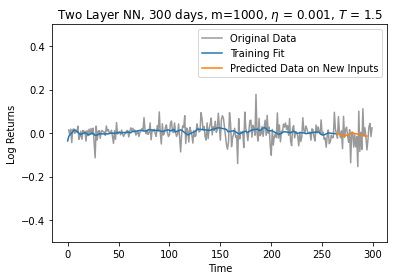

In [12]:
x_pred_300 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_300 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_300 = predict(x_pred_300, a4, w4, b4)
y_pred2_300 = predict(x_pred2_300, a4, w4, b4)
x_pred_300 *= 300
x_pred2_300 *= 300
plt.plot(x_300*300,y_300, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_300, y_pred_300, label = 'Training Fit')
plt.plot(x_pred2_300, y_pred2_300, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, 300 days, m=1000, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_300_pred_reg',bbox_inches = 'tight')
plt.show()

In [13]:
# 600 days 
path_data = path_to_save + "BTC_600.csv"
df_600 = pd.read_csv(path_data)

pre_x_val = list(df_600['time.1'])
pre_y_val = list(df_600.logreturn)


#90% train test split by time index
x_600 = np.array([float(num) for num in pre_x_val]).reshape(599,1)
x_600 /= 600
y_600 = np.array([float(num) for num in pre_y_val]).reshape(599,1)

In [14]:
M = 1200
tau =1.5
a5,w5,b5 = initialize_weights(M, tau)
a5,w5,b5,loss_history5 = gradient_descent(x_600[0:540],a5,w5,b5,y_600[0:540],lr=.001,lambd=0.005)

0.005
Loss at 0: 1016.1275113755052
Loss at 10000: 9.978493569145265
Loss at 20000: 9.029101706628596
Loss at 30000: 8.169914344068657
Loss at 40000: 7.392545552239113
Loss at 50000: 6.6891485721927415
Loss at 60000: 6.052728998928043
Loss at 70000: 5.476832776291016
Loss at 80000: 4.955763665019562
Loss at 90000: 4.484253505442137


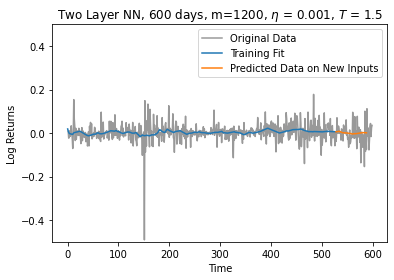

In [15]:
x_pred_600 = np.linspace(0,0.88,400).reshape(400,1)
x_pred2_600 = np.linspace(0.88,0.98,400).reshape(400,1)
y_pred_600 = predict(x_pred_600, a5, w5, b5)
y_pred2_600 = predict(x_pred2_600, a5, w5, b5)
x_pred_600 *= 600
x_pred2_600 *= 600
plt.plot(x_600*600,y_600, alpha = 0.8, color = 'grey', label = "Original Data")
plt.plot(x_pred_600, y_pred_600, label = 'Training Fit')
plt.plot(x_pred2_600, y_pred2_600, label = 'Predicted Data on New Inputs')
plt.ylim(-.5, .5)
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Two Layer NN, 600 days, m=1200, $\eta$ = 0.001, $T$ = 1.5")
plt.legend()
plt.savefig(path_to_save + 'two_layer_NN_600_pred_reg',bbox_inches = 'tight')
plt.show()

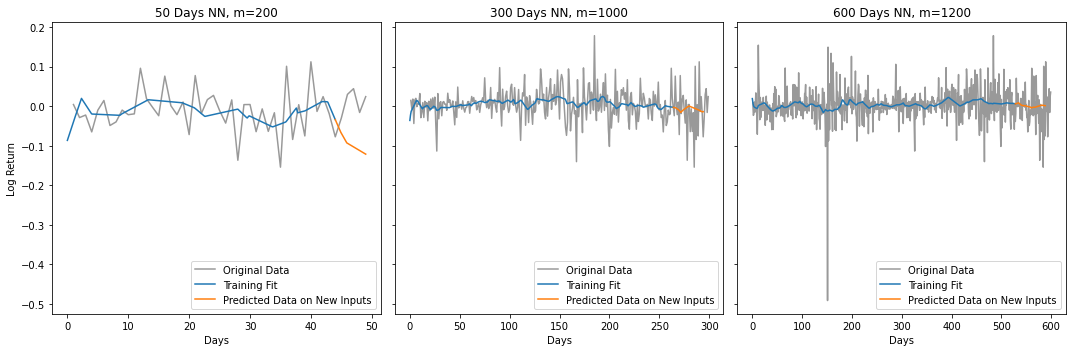

In [16]:
figure, axes = plt.subplots(nrows=1, ncols=3,sharey = True, figsize = (15, 5))
axes[0].plot(x_50*50,y_50, alpha = 0.8, color = 'grey', label = "Original Data")
axes[0].plot(x_pred_50, y_pred_50, label = 'Training Fit')
axes[0].plot(x_pred2_50, y_pred2_50, label = 'Predicted Data on New Inputs')
axes[0].legend(loc = 'lower right')
axes[1].plot(x_300*300,y_300, alpha = 0.8, color = 'grey', label = "Original Data")
axes[1].plot(x_pred_300, y_pred_300, label = 'Training Fit')
axes[1].plot(x_pred2_300, y_pred2_300, label = 'Predicted Data on New Inputs')
axes[1].legend(loc = 'lower right')
axes[2].plot(x_600*600,y_600, alpha = 0.8, color = 'grey', label = "Original Data")
axes[2].plot(x_pred_600, y_pred_600, label = 'Training Fit')
axes[2].plot(x_pred2_600, y_pred2_600, label = 'Predicted Data on New Inputs')
axes[2].legend(loc = 'lower right')
axes[0].set_title('50 Days NN, m=200')
axes[0].set_xlabel('Days')
axes[1].set_title('300 Days NN, m=1000')
axes[1].set_xlabel('Days')
axes[2].set_title('600 Days NN, m=1200')
axes[2].set_xlabel('Days')
axes[0].set_ylabel('Log Return')
figure.tight_layout()
figure.savefig(path_to_save + 'two_layer_NN_pred_reg',bbox_inches = 'tight')

In [17]:
lambd =0.005
print("test loss for 50, 300, 600 days with regularization is as follows: \n")
loss4 = 1/(2*5) * np.sum((predict(x_50[44:], a3, w3, b3) - y_50[44:])**2) + (lambd/2 * (np.linalg.norm(a3)**2 + np.linalg.norm(w3)**2))
print(loss4)

loss5 = 1/(2*30) * np.sum((predict(x_300[270:], a4, w4, b4) - y_300[270:])**2)+ (lambd/2 * (np.linalg.norm(a4)**2 + np.linalg.norm(w4)**2))
print(loss5)


loss6 = 1/(2*60) * np.sum((predict(x_600[540:], a5, w5, b5) - y_600[540:])**2)+ (lambd/2 * (np.linalg.norm(a5)**2 + np.linalg.norm(w5)**2))
print(loss6)

test loss for 50, 300, 600 days with regularization is as follows: 

0.8672214346093812
3.711252640402613
4.058027583012581


## Splines

{'50': [0.0003750354294597188, 0.0003750354294597188, 0.0003750354294597188], '300': [172689.6608291894, 118972.12012633457, 0.0017414044019959734], '600': [411007.83978253487, 592.3300194702526, 303.14158739463517]}


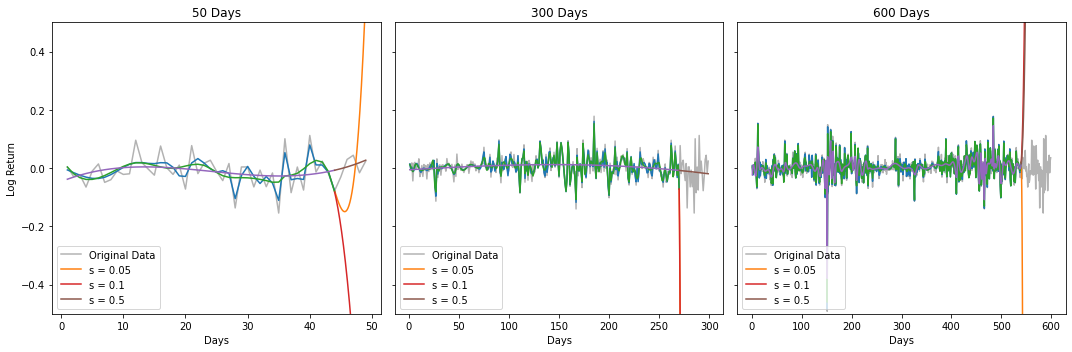

In [65]:
loss_dict = {'50':[], '300':[], '600':[]}
s = [0.05, 0.1, 0.5]
# 50 days 
path_data = path_to_save + "BTC_50.csv"
df_50 = pd.read_csv(path_data)

pre_x_val = list(df_50['time.1'])
pre_y_val = list(df_50.logreturn)

#90% train test split by time index
x_50 = np.array([float(num) for num in pre_x_val]).reshape(49,1)
y_50 = np.array([float(num) for num in pre_y_val]).reshape(49,1)



figure, axes = plt.subplots(nrows=1, ncols=3,sharey = True, figsize = (15, 5))
axes[0].plot(x_50,y_50, alpha = 0.6, color='grey', linestyle='-', label = "Original Data")
axes[0].set_ylabel('Log Return')
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlabel('Days')
axes[0].set_title("50 Days")

for val in s: 
  x_pred = np.linspace(44,49,400).reshape(400,1)
  spl = UnivariateSpline(x_50[0:44], y_50[0:44], s = val)
  axes[0].plot(x_50[0:44], spl(x_50[0:44]))
  axes[0].plot(x_pred, spl(x_pred), label = 's = ' + str(val))
  y_pred = spl(x_50[44:])
  loss_dict['50'].append(1/(2*5) * np.sum((y_pred_50 - y_50[44:])**2)) 

axes[0].legend(loc='lower left')

# 300 days 
path_data = path_to_save + "BTC_300.csv"
df_300 = pd.read_csv(path_data)

pre_x_val = list(df_300['time.1'])
pre_y_val = list(df_300.logreturn)


#90% train test split by time index
x_300 = np.array([float(num) for num in pre_x_val]).reshape(299,1)
y_300 = np.array([float(num) for num in pre_y_val]).reshape(299,1)
axes[1].plot(x_300,y_300, alpha = 0.6, color='grey', linestyle='-', label = "Original Data")
axes[1].set_xlabel('Days')
axes[1].set_title("300 Days")

for val in s: 
  x_pred = np.linspace(270,299,400).reshape(400,1)
  spl = UnivariateSpline(x_300[0:270], y_300[0:270], s = val)
  axes[1].plot(x_300[0:270], spl(x_300[0:270]))
  axes[1].plot(x_pred, spl(x_pred), label = 's = ' + str(val))
  y_pred = spl(x_300[270:])
  loss_dict['300'].append(1/(2*30) * np.sum((y_pred - y_300[270:])**2)) 

axes[1].legend(loc='lower left')

# 600 days 
path_data = path_to_save + "BTC_600.csv"
df_600 = pd.read_csv(path_data)

pre_x_val = list(df_600['time.1'])
pre_y_val = list(df_600.logreturn)


#90% train test split by time index
x_600 = np.array([float(num) for num in pre_x_val]).reshape(599,1)
y_600 = np.array([float(num) for num in pre_y_val]).reshape(599,1)
axes[2].plot(x_600,y_600, alpha = 0.6, color='grey', linestyle='-', label = "Original Data")
axes[2].set_xlabel('Days')
axes[2].set_title("600 Days")

for val in s: 
  x_pred = np.linspace(540,599,400).reshape(400,1)
  spl = UnivariateSpline(x_600[0:540], y_600[0:540], s = val)
  axes[2].plot(x_600[0:540], spl(x_600[0:540]))
  axes[2].plot(x_pred, spl(x_pred), label = 's = ' + str(val))
  y_pred = spl(x_600[540:])
  loss_dict['600'].append(1/(2*60) * np.sum((y_pred - y_600[540:])**2)) 

axes[2].legend(loc='lower left')
figure.tight_layout()
figure.savefig(path_to_save + 'univariate_spline',bbox_inches = 'tight', dpi=400)
print(loss_dict)
